In [51]:
import boto3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import math
import random
from decimal import Decimal, getcontext
import pandas_market_calendars as mcal
import ast
from sklearn.preprocessing import StandardScaler
import pytz

s3 = boto3.client('s3')

training_bucket = "icarus-research-data"
training_prefix = 'training_datasets/expanded_1d_datasets/'

# Create a calendar
nyse = mcal.get_calendar('NYSE')
holidays = nyse.regular_holidays
market_holidays = holidays.holidays()

weekly_expiries = ['SPY', 'IVV', 'QQQ', 'GLD', 'IWM', 'EFA', 'XLK', 'XLV', 'TLT', 'LQD', 'XLE', 'TQQQ', 'SQQQ', 'SPXS', 'SPXL', 'SOXL', 'SOXS', 'MMM', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 
                   'AAP', 'AFL', 'ALB', 'ALGN', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMD', 'AAL', 'AXP', 'AIG', 'ABC', 'AMGN', 'ADI', 'APA', 'AAPL', 'AMAT', 'ANET', 'T', 'ADSK', 'BAC', 'BBWI', 'BAX', 'BBY', 'BIIB', 
                   'BLK', 'BA', 'BKNG', 'BMY', 'AVGO', 'CZR', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CAT', 'CBOE', 'CNC', 'CF', 'SCHW', 'CHTR', 'CVX', 'CMG', 'CI', 'CSCO', 'C', 'CLX', 'CME', 'KO', 'CMCSA', 'CMA', 'CAG', 
                   'COP', 'STZ', 'GLW', 'COST', 'CTRA', 'CSX', 'CVS', 'DHI', 'DHR', 'DE', 'DAL', 'DVN', 'DLR', 'DFS', 'DISH', 'DIS', 'DG', 'DLTR', 'DPZ', 'DOW', 'DD', 'EBAY', 'EA', 'ELV', 'LLY', 'EMR', 'ENPH', 'EOG', 'EQT', 
                   'ETSY', 'EXPE', 'XOM', 'FDX', 'FITB', 'FSLR', 'FI', 'F', 'FTNT', 'FOXA', 'FCX', 'GEHC', 'GNRC', 'GD', 'GE', 'GM', 'GILD', 'GS', 'HAL', 'HSY', 'HES', 'HD', 'HON', 'HRL', 'HPQ', 'HUM', 'HBAN', 'IBM', 'ILMN', 
                   'INTC', 'IP', 'INTU', 'ISRG', 'JNJ', 'JPM', 'JNPR', 'KEY', 'KMB', 'KMI', 'KLAC', 'KHC', 'KR', 'LRCX', 'LVS', 'LEN', 'LMT', 'LOW', 'MRO', 'MPC', 'MAR', 'MA', 'MTCH', 'MCD', 'MCK', 'MDT', 'MRK', 'META', 'MET', 
                   'MGM', 'MU', 'MSFT', 'MRNA', 'MDLZ', 'MS', 'MOS', 'NTAP', 'NFLX', 'NEM', 'NKE', 'NSC', 'NOC', 'NCLH', 'NUE', 'NVDA', 'NXPI', 'OXY', 'ON', 'ORCL', 'PARA', 'PYPL', 'PEP', 'PFE', 'PCG', 'PM', 'PSX', 'PXD', 'PNC', 
                   'PPG', 'PG', 'PHM', 'QCOM', 'RTX', 'REGN', 'ROST', 'RCL', 'SPGI', 'CRM', 'SLB', 'STX', 'NOW', 'SWKS', 'SEDG', 'SO', 'LUV', 'SBUX', 'TMUS', 'TROW', 'TTWO', 'TPR', 'TGT', 'TSLA', 'TXN', 'TMO', 'TJX', 'TSCO', 'TFC', 
                   'TSN', 'USB', 'ULTA', 'UNP', 'UAL', 'UPS', 'URI', 'UNH', 'VLO', 'VZ', 'VRTX', 'VFC', 'V', 'WBA', 'WMT', 'WBD', 'WM', 'WFC', 'WDC', 'WHR', 'WMB', 'WYNN', 'ZION']

leveraged_etfs = ["TQQQ","SQQQ","SPXS","SPXL","SOXL","SOXS"]
high_vol = ['COIN','BILI','UPST','CVNA',"TQQQ","SQQQ","SPXS","SPXL","SOXL","SOXS","NIO","BABA","ROKU","RBLX","SE","SNAP","LCID",'RIVN',"BIDU","FUTU","TSLA","JD"]
indexes = ['QQQ','IWM','TLT','VXX','SPY']


def create_training_data_local(key_list, prefix, bucket_name, alert_type, start_date, end_date):
    df_list = []
    hours = [10,11,12,13,14,15]
    start = start_date.split(' ')[0]
    end = end_date.split(' ')[0]
    # print(file_key)
    for key in key_list:
        for hour in hours:
            try:
                data = s3.get_object(Bucket=bucket_name, Key=f'{prefix}{key}/{alert_type}/{hour}.csv')
                df = pd.read_csv(data.get("Body")) 
                df = df.loc[~df['symbol'].isin(high_vol)]
                df = df.iloc[:8]
                df_list.append(df)
                # df['hour'] = hour
            except:
                continue

    data = pd.concat(df_list)
    # data = data.loc[~data['symbol'].isin(index)]
    # data = data.loc[~data['symbol'].isin(laggards)]
    data.reset_index(drop=True, inplace=True)

    # data['date'] = pd.to_datetime(data['date'])
    # data['day_of_week'] = data['dt'].apply(lambda x: x.dayofweek)
    # data = data.round(3)
    data.replace([np.inf, -np.inf], 0, inplace=True)

    data.to_csv(f'/Users/charlesmiller/Documents/model_tester_data/GAIN/{start}_{end}T8.csv', index=False)

    return data

def pull_training_data_local(end_date,start_date):
    data = pd.read_csv(f'/Users/charlesmiller/Documents/model_tester_data/IDX/2018-04-01_2023-10-21.csv')
    data['dt'] = pd.to_datetime(data['date'])
    data = data.loc[data['dt'] <= end_date]
    # data.replace([np.inf, -np.inf], 0, inplace=True)

    return data


def pull_validation_data_local(end_date,start_date):
    data = pd.read_csv(f'/Users/charlesmiller/Documents/model_tester_data/IDX/2018-04-01_2023-10-21.csv')
    data['dt'] = pd.to_datetime(data['date'])
    data = data.loc[data['dt'] <= end_date]
    data = data.loc[data['dt'] >= start_date]
    data.replace([np.inf, -np.inf], 0, inplace=True)

    return data

In [49]:
dataset = pull_training_data_local(start_date=datetime(2018,1,1),end_date=datetime(2023,10,28))
print(dataset['three_max'].describe())


count    25185.000000
mean         0.017797
std          0.016865
min          0.000000
25%          0.006074
50%          0.013239
75%          0.024418
max          0.207037
Name: three_max, dtype: float64
   Unnamed: 0.1           v       o       c       h       l        date  hour  \
0             0   6224596.0  159.00  158.20  159.74  157.93  2018-04-02    10   
1             1   2384891.0  151.52  150.99  152.07  150.91  2018-04-02    10   
2             2   8398587.0  262.55  261.77  263.13  261.49  2018-04-02    10   
3             0  10508880.0  159.00  157.36  159.74  157.26  2018-04-02    11   
4             1   3968327.0  151.52  150.19  152.07  150.09  2018-04-02    11   

  symbol           t  ...  Unnamed: 0.2  roc_diff  range_vol_diff5  \
0    QQQ  1522675800  ...           NaN    -7.361           -0.019   
1    IWM  1522675800  ...           NaN    -4.918           -0.008   
2    SPY  1522675800  ...           NaN    -5.987           -0.013   
3    QQQ  1522677600  ...

In [53]:
val = pull_validation_data_local(start_date=datetime(2022,10,7),end_date=datetime(2022,10,13))
print(val['three_max'].describe())


count    90.000000
mean      0.027026
std       0.016569
min       0.001481
25%       0.016341
50%       0.024530
75%       0.035404
max       0.069152
Name: three_max, dtype: float64


<Axes: xlabel='month'>

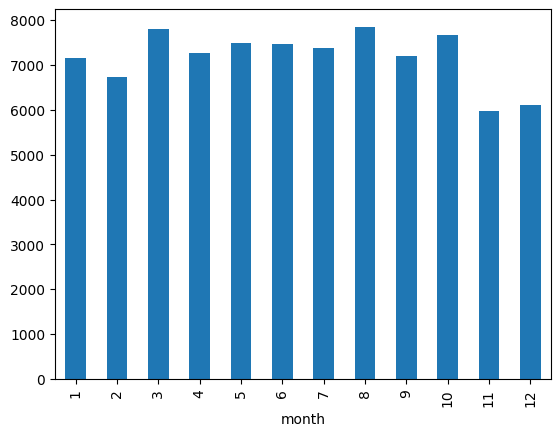

In [10]:
month = dataset.groupby(['month'])
month_count = month['three_max'].count()
month_count.plot(kind='bar')

In [12]:
new_sym = s3.list_objects(Bucket="icarus-research-data", Prefix=f"backtesting_data/inv_alerts/TSSIM1_newSYM+_custHypP18/VDIFFC_1d/")
list_of_keys = [x['Key'] for x in new_sym['Contents']]
dfs = []
for key in list_of_keys:
    data = s3.get_object(Bucket="icarus-research-data", Key=key)
    df = pd.read_csv(data.get("Body"))
    dfs.append(df)
new_sym_df = pd.concat(dfs)

In [13]:
tr = s3.list_objects(Bucket="icarus-research-data", Prefix=f"backtesting_data/inv_alerts/TSSIM1_TR10_custHypP175/VDIFFC_1d/")
list_of_keys = [x['Key'] for x in tr['Contents']]
dfs = []
for key in list_of_keys:
    data = s3.get_object(Bucket="icarus-research-data", Key=key)
    df = pd.read_csv(data.get("Body"))
    dfs.append(df)
tr_df = pd.concat(dfs)

In [18]:
print(new_sym_df['symbol'].unique().tolist())
print(len(new_sym_df['symbol'].unique()))

['CCL', 'AAPL', 'AMD', 'F', 'NVDA', 'AMZN', 'AAL', 'XOM', 'NCLH', 'SOFI', 'PLTR', 'INTC', 'SHOP', 'BAC', 'MSFT', 'VZ', 'PINS', 'GOOGL', 'META', 'PYPL', 'UBER', 'LYFT', 'MRNA', 'TSM', 'JPM', 'WFC', 'NFLX', 'UAL', 'PFE', 'KO', 'GOOG', 'TWLO', 'WBD', 'SQ', 'DIS', 'WMT', 'TGT', 'CSCO', 'C', 'CRWD', 'CRM', 'DOCU', 'DAL', 'NKE', 'MU', 'ABNB', 'PANW', 'ZM', 'SNOW', 'GE', 'BA', 'JNJ', 'TDOC', 'PG', 'SBUX', 'QCOM', 'HD', 'ORCL', 'DDOG', 'OKTA', 'V', 'ARM', 'MS', 'HOOD', 'TTD', 'AMAT', 'CHWY']
67


In [19]:
print(tr_df['symbol'].unique().tolist())
print(len(tr_df['symbol'].unique()))

['MGM', 'NCLH', 'CZR', 'GE', 'RTX', 'GM', 'TGT', 'NOW', 'OKTA', 'LOW', 'MMM', 'CMG', 'BA', 'COST', 'AVGO', 'PFE', 'BAC', 'ETSY', 'ABNB', 'JPM', 'NFLX', 'AMAT', 'AXP', 'DE', 'AAL', 'TXN', 'UBER', 'CAT', 'F', 'VZ', 'DAL', 'ORCL', 'TWLO', 'CVX', 'TSM', 'SQ', 'PINS', 'BKNG', 'TEAM', 'ZS', 'DOCU', 'MA', 'PANW', 'HD', 'PLTR', 'AAPL', 'MS', 'TDOC', 'SNOW', 'FDX', 'MRNA', 'CRWD', 'WFC', 'CHWY', 'ADBE', 'INTC', 'WBD', 'PYPL', 'CRM', 'CCL', 'C', 'NVDA', 'DDOG', 'UAL', 'MU', 'UPS', 'AMD', 'RCL', 'ZM', 'DG', 'QCOM', 'XOM', 'GOOGL', 'DIS', 'NKE', 'LMT', 'V', 'GS', 'AMZN', 'TTD', 'GOOG', 'MSFT', 'CSCO', 'SBUX', 'ARM']
85


In [21]:
dataset.loc[dataset['symbol'] == 'PAYC']

,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.1,Unnamed: 0,Unnamed: 0.2,v,o,c,h,...,n_y,roc_diff,range_vol_diff5,close_diff_deviation3,close_diff_deviation,day_of_week,day_of_month,month,year,dt
62043,NaN,405.0,405.0,405.0,405.0,405.0,1263661.0,366.21,364.94,367.45,...,148.0,8.721,NaN,NaN,NaN,2,9,2,2022,2022-02-09
62053,NaN,405.0,405.0,405.0,405.0,405.0,1263661.0,366.21,364.94,367.45,...,44.0,8.721,NaN,NaN,NaN,2,9,2,2022,2022-02-09
62063,NaN,405.0,405.0,405.0,405.0,405.0,1263661.0,366.21,364.94,367.45,...,51.0,8.721,NaN,NaN,NaN,2,9,2,2022,2022-02-09
62073,NaN,405.0,405.0,405.0,405.0,405.0,1263661.0,366.21,364.94,367.45,...,99.0,8.721,NaN,NaN,NaN,2,9,2,2022,2022-02-09
62083,NaN,405.0,405.0,405.0,405.0,405.0,1263661.0,366.21,364.94,367.45,...,16.0,8.721,NaN,NaN,NaN,2,9,2,2022,2022-02-09
62093,NaN,405.0,405.0,405.0,405.0,405.0,1263661.0,366.21,364.94,367.45,...,33.0,8.721,NaN,NaN,NaN,2,9,2,2022,2022-02-09


In [24]:
# all_csv = s3.get_object(Bucket='inv-alerts', Key=f'all_alerts/2022/03/03/11.csv')
all_df = pd.read_csv(all_csv.get("Body"))
symbols = all_df['symbol'].unique().tolist()
print(symbols)

['SPY', 'IVV', 'VOO', 'VTI', 'QQQ', 'VEA', 'IEFA', 'VTV', 'BND', 'AGG', 'VUG', 'VWO', 'IEMG', 'IWF', 'VIG', 'IJH', 'IJR', 'GLD', 'VGT', 'VXUS', 'VO', 'IWM', 'BNDX', 'EFA', 'IWD', 'VYM', 'SCHD', 'XLK', 'ITOT', 'VB', 'VCIT', 'XLV', 'TLT', 'BSV', 'VCSH', 'LQD', 'XLE', 'VEU', 'RSP', 'TQQQ', 'SQQQ', 'SPXS', 'SPXL', 'SOXL', 'SOXS', 'MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ATVI', 'ADM', 'ADBE', 'ADP', 'AAP', 'AES', 'AFL', 'A', 'APD', 'AKAM', 'ALK', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL', 'GOOG', 'MO', 'AMZN', 'AMCR', 'AMD', 'AEE', 'AAL', 'AEP', 'AXP', 'AIG', 'AMT', 'AWK', 'AMP', 'ABC', 'AME', 'AMGN', 'APH', 'ADI', 'ANSS', 'AON', 'APA', 'AAPL', 'AMAT', 'APTV', 'ACGL', 'ANET', 'AJG', 'AIZ', 'T', 'ATO', 'ADSK', 'AZO', 'AVB', 'AVY', 'AXON', 'BKR', 'BAC', 'BBWI', 'BAX', 'BDX', 'WRB', 'BRK.B', 'BBY', 'BIO', 'TECH', 'BIIB', 'BLK', 'BK', 'BA', 'BKNG', 'BWA', 'BXP', 'BSX', 'BMY', 'AVGO', 'BR', 'BRO', 'BF.B', 'BG', 'CHRW', 'CDNS', 'CZR', 'CPT', 'CPB', 'COF', 'CAH', 'KMX', 'CCL', 'CARR', 'CTLT'